**Name:** Alexia Ntantouri

**AEM:** 3871

**IMPORTANT NOTE:**

It is recommended to read this notebook along with the PDF report that presents the results in a comprehensive manner.

In [ ]:
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.svm import SVC

from timeit import default_timer as timer

from keras.datasets import cifar10

import matplotlib.pyplot as plt

In [ ]:
# load the dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# normalize the values
X_train, X_test = X_train / 255.0, X_test / 255.0

X_train_not_reshaped, X_test_not_reshaped = X_train, X_test

print("X_train dimensions: " + str(X_train.shape))
print("y_train dimensions: " + str(y_train.shape) + "\n")

print("X_test dimensions: " + str(X_test.shape))
print("y_test dimensions: " + str(y_test.shape))

170498071/170498071 [==============================] - 5s 0us/step
X_train dimensions: (50000, 32, 32, 3)
y_train dimensions: (50000, 1)

X_test dimensions: (10000, 32, 32, 3)
y_test dimensions: (10000, 1)


In [ ]:
# Flatten the original labels if they are in a 2D format
y_train_flat = y_train.flatten()
y_test_flat = y_test.flatten()

print("y_train dimensions: " + str(y_train.shape))
print("y_test dimensions: " + str(y_test.shape))

y_train dimensions: (50000, 1)
y_test dimensions: (10000, 1)


In [ ]:
# classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print("Classes: ", str(len(classes)), "\n")

for i in range(len(classes)):
  print(classes[i])

Classes:  10 

airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck


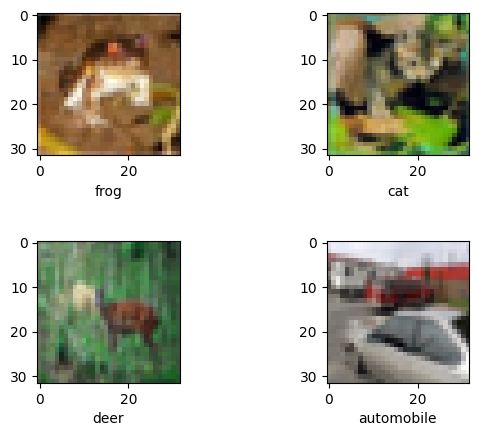

In [ ]:
# image samples

plt.subplots_adjust(wspace=0.4, hspace=0.6)

plt.subplot(2,2,1)
plt.imshow(X_train[0], cmap=plt.get_cmap('CMRmap'))
plt.xlabel(classes[y_train[0][0]])

plt.subplot(2,2,2)
plt.imshow(X_train[10254], cmap=plt.get_cmap('CMRmap'))
plt.xlabel(classes[y_train[10254][0]])

plt.subplot(2,2,3)
plt.imshow(X_train[20253], cmap=plt.get_cmap('CMRmap'))
plt.xlabel(classes[y_train[20253][0]])

plt.subplot(2,2,4)
plt.imshow(X_train[49999], cmap=plt.get_cmap('CMRmap'))
plt.xlabel(classes[y_train[49999][0]])

plt.show()

In [ ]:
# reshape the data

# reshape the 4D array into a 2D array
# the first dimension (number of samples) should remain the same (50000)
# the -1 in the second dimension indicates that NumPy should automatically calculate
# the size of that dimension based on the total number of elements, maintaining the integrity of the data.
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

print("X_train dimensions: " + str(X_train.shape))
print("X_test dimensions: " + str(X_test.shape) + "\n")

X_train dimensions: (50000, 3072)
X_test dimensions: (10000, 3072)



In [ ]:
from keras.utils import to_categorical

# Labeling (one hot encoding)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print("y_train dimensions: " + str(y_train.shape))
print("y_test dimensions: " + str(y_test.shape))

y_train dimensions: (50000, 10)
y_test dimensions: (10000, 10)


# **PCA**

I used sklearn's **PCA** to hold **90%** of the variance of the data and the dimensionality of the dataset decreased from **3071** to **99** features (**-96.7773%** decrease).

In [ ]:
from sklearn.decomposition import PCA

start = timer()

# PCA will hold 90% of the variance
pca = PCA(0.9)
pca.fit(X_train)

end = timer()
print("Time: ", end - start) # time in seconds

# PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
#   svd_solver='auto', tol=0.0, whiten=False)

print(pca.n_components_)

Time:  189.530175585
99


In [ ]:
train_pca = pca.transform(X_train)
test_pca = pca.transform(X_test)

In [ ]:
print(train_pca.shape)
print(test_pca.shape)

print(y_train.shape)
print(y_test.shape)

(50000, 99)
(10000, 99)
(50000, 10)
(10000, 10)


# **Radial Basis Function (RBF) Neural Network**

An Radial Basis Function (RBF) neural network is a type of artificial neural network that uses radial basis functions as activation functions. It is a three-layer network that consists of an input layer, a hidden layer with radial basis function neurons, and an output layer.

**Input Layer:**

This layer receives the input data and passes it to the hidden layer.

**Hidden Layer:**

The hidden layer of an RBF neural network contains neurons with radial basis functions as activation functions. The radial basis function computes the similarity between the input data and the center of the neuron. The output of each hidden neuron is a measure of how similar the input is to the center of that neuron.

**Radial Basis Function (RBF):**

The radial basis function is typically a bell-shaped curve that is centered at a specific point. The output of the RBF neuron is high when the input is close to the center and decreases as the input moves away from the center. Common choices for the radial basis function include Gaussian functions.

**Output Layer:**

The output layer aggregates the information from the hidden layer and produces the final output of the network.

Code for RBF Layer from:

*Vidnerová, Petra. RBF-Keras: an RBF Layer for Keras Library. 2019. Available at https://github.com/PetraVidnerova/rbf_keras*

In [ ]:
from keras.initializers import Initializer
from sklearn.cluster import KMeans

class InitCentersKMeans(Initializer):
    """ Initializer for initialization of centers of RBF network
        by clustering the given data set.
    # Arguments
        X: matrix, dataset
    """

    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter

    def __call__(self, shape, dtype=None):
        print("Shape of initializer:", shape)
        print("Shape of dataset X:", self.X.shape)
        assert shape[1] == self.X.shape[1]

        n_centers = shape[0]
        km = KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=0)
        km.fit(self.X)
        return km.cluster_centers_

In [ ]:
from keras import backend as K
from keras.layers import Layer
from keras.initializers import RandomUniform, Initializer, Constant
import pandas as pd

class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.

    # Arguments
        X: matrix, dataset to choose the centers from (random rows
          are taken as centers)
    """

    def __init__(self, X):
        self.X = X

    def __call__(self, shape, dtype=None):
        print("Shape of initializer:", shape)
        print("Shape of dataset X:", self.X.shape)
        assert shape[1] == self.X.shape[1]
        idx = np.random.randint(self.X.shape[0], size=shape[0])

        # type checking to access elements of data correctly
        if type(self.X) == np.ndarray:
            return self.X[idx, :]
        elif type(self.X) == pd.core.frame.DataFrame:
            return self.X.iloc[idx, :]


class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.

    # Example

    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```


    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas

    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(
                                         value=self.init_betas),
                                     # initializer='ones',
                                     trainable=True)

        super(RBFLayer, self).build(input_shape)

    def call(self, x):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.betas * K.sum(H**2, axis=1))

        # C = self.centers[np.newaxis, :, :]
        # X = x[:, np.newaxis, :]

        # diffnorm = K.sum((C-X)**2, axis=-1)
        # ret = K.exp( - self.betas * diffnorm)
        # return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# **Randomized Search**

I used sklearn's RandomizedSearchCV to find the best hyperparameters for the model.

**From sklearn:**

*In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter.*

RandomizedSearchCV returned a model that achieves **38.43% accuracy**.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input

# Function to create the model in order to use GridSearchCV for hyperparameter tuning.
def create_model(optimizer='adam', loss='mean_squared_error', betas=0.1, nodes=120):
    model = Sequential()
    model.add(Input(shape=train_pca[0].shape))
    model.add(RBFLayer(nodes, initializer=InitCentersKMeans(train_pca), betas=betas))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [ ]:
!pip install scikeras

In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

model = KerasClassifier(build_fn=create_model, optimizer='adam', loss='mean_squared_error', betas=0.5, nodes=120)

optimizers = ['adam']
betas = np.array([0.1, 0.5, 1.0, 2.0])
nodes = np.array([80, 100, 120, 150, 200])

epochs = np.array([25, 50, 100, 150])
batches = np.array([20, 40, 60])

param_grid = dict(optimizer=optimizers,
                  betas=betas,
                  nodes=nodes,
                  epochs=epochs,
                  batch_size=batches)

grid = RandomizedSearchCV(estimator=model,
                          param_distributions=param_grid,
                          cv=2,
                          n_iter=5,
                          verbose=1,
                          random_state=1,
                          n_jobs=-1)

start = timer()

grid_result = grid.fit(train_pca, y_train, verbose=0)

end = timer()
print("Search time: ", end - start) # time in seconds

Fitting 2 folds for each of 5 candidates, totalling 10 fits


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of initializer: (100, 99)
Shape of dataset X: (50000, 99)
Search time:  3891.4470411149996


In [ ]:
print("Best model: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best model: 0.384300 using {'optimizer': 'adam', 'nodes': 100, 'epochs': 50, 'betas': 0.1, 'batch_size': 40}


# **Different Number of Neurons in the Hidden Layer**

In this section, we experiment with number of neurons in the hidden layer. The results show that having 150 neurons gives us the highest accuracy.

## neurons = 120

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input

optimizer='adam'
loss='categorical_crossentropy'
betas = 0.1
nodes = 120

model = Sequential()
model.add(Input(shape=train_pca[0].shape))
model.add(RBFLayer(nodes, initializer=InitCentersKMeans(train_pca), betas=betas))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

Shape of initializer: (120, 99)
Shape of dataset X: (50000, 99)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
start = timer()

# The best parameters are the defaults
history = model.fit(train_pca, y_train, epochs=100, batch_size=20,
                    validation_data=(test_pca,y_test), shuffle=True,
                    verbose=1)

end = timer()
print("Training time: ", end - start) # time in seconds

Epoch 1/100
2500/2500 [==============================] - 18s 7ms/step - loss: 2.0414 - accuracy: 0.2547 - val_loss: 1.9726 - val_accuracy: 0.2895
Epoch 2/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.9069 - accuracy: 0.3109 - val_loss: 1.8779 - val_accuracy: 0.3274
Epoch 3/100
2500/2500 [==============================] - 18s 7ms/step - loss: 1.8571 - accuracy: 0.3314 - val_loss: 1.8307 - val_accuracy: 0.3531
Epoch 4/100
2500/2500 [==============================] - 18s 7ms/step - loss: 1.8292 - accuracy: 0.3418 - val_loss: 1.8131 - val_accuracy: 0.3497
Epoch 5/100
2500/2500 [==============================] - 18s 7ms/step - loss: 1.8083 - accuracy: 0.3491 - val_loss: 1.8021 - val_accuracy: 0.3501
Epoch 6/100
2500/2500 [==============================] - 18s 7ms/step - loss: 1.7940 - accuracy: 0.3573 - val_loss: 1.7640 - val_accuracy: 0.3785
Epoch 7/100
2500/2500 [==============================] - 20s 8ms/step - loss: 1.7812 - accuracy: 0.3618 - val_loss: 1.7765 -

In [ ]:
# Evaluate the model on the train set
train_loss, train_acc = model.evaluate(train_pca, y_train)
print("Train accuracy:", train_acc)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_pca, y_test)
print("Test accuracy:", test_acc)

1563/1563 [==============================] - 7s 5ms/step - loss: 1.6479 - accuracy: 0.4121
Train accuracy: 0.4120599925518036
313/313 [==============================] - 1s 5ms/step - loss: 1.6743 - accuracy: 0.4067
Test accuracy: 0.4066999852657318


## neurons = 150

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input

optimizer='adam'
loss='categorical_crossentropy'
betas = 0.1
nodes = 150

model = Sequential()
model.add(Input(shape=train_pca[0].shape))
model.add(RBFLayer(nodes, initializer=InitCentersKMeans(train_pca), betas=betas))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

Shape of initializer: (150, 99)
Shape of dataset X: (50000, 99)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
start = timer()

# The best parameters are the defaults
history = model.fit(train_pca, y_train, epochs=100, batch_size=20,
                    validation_data=(test_pca,y_test), shuffle=True,
                    verbose=1)

end = timer()
print("Training time: ", end - start) # time in seconds

Epoch 1/100
2500/2500 [==============================] - 23s 9ms/step - loss: 2.0269 - accuracy: 0.2645 - val_loss: 1.9185 - val_accuracy: 0.3151
Epoch 2/100
2500/2500 [==============================] - 20s 8ms/step - loss: 1.8963 - accuracy: 0.3197 - val_loss: 1.8606 - val_accuracy: 0.3418
Epoch 3/100
2500/2500 [==============================] - 21s 8ms/step - loss: 1.8466 - accuracy: 0.3353 - val_loss: 1.8042 - val_accuracy: 0.3638
Epoch 4/100
2500/2500 [==============================] - 20s 8ms/step - loss: 1.8192 - accuracy: 0.3470 - val_loss: 1.8299 - val_accuracy: 0.3459
Epoch 5/100
2500/2500 [==============================] - 20s 8ms/step - loss: 1.7978 - accuracy: 0.3550 - val_loss: 1.7976 - val_accuracy: 0.3541
Epoch 6/100
2500/2500 [==============================] - 20s 8ms/step - loss: 1.7838 - accuracy: 0.3626 - val_loss: 1.7835 - val_accuracy: 0.3593
Epoch 7/100
2500/2500 [==============================] - 21s 8ms/step - loss: 1.7698 - accuracy: 0.3668 - val_loss: 1.7863 -

In [ ]:
# Evaluate the model on the train set
train_loss, train_acc = model.evaluate(train_pca, y_train)
print("Train accuracy:", train_acc)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_pca, y_test)
print("Test accuracy:", test_acc)

1563/1563 [==============================] - 9s 6ms/step - loss: 1.6105 - accuracy: 0.4300
Train accuracy: 0.43004000186920166
313/313 [==============================] - 2s 5ms/step - loss: 1.6361 - accuracy: 0.4269
Test accuracy: 0.4268999993801117


## neurons = 200

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input

optimizer='adam'
loss='categorical_crossentropy'
betas = 0.1
nodes = 200

model = Sequential()
model.add(Input(shape=train_pca[0].shape))
model.add(RBFLayer(nodes, initializer=InitCentersKMeans(train_pca), betas=betas))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

Shape of initializer: (200, 99)
Shape of dataset X: (50000, 99)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
start = timer()

# The best parameters are the defaults
history = model.fit(train_pca, y_train, epochs=100, batch_size=20,
                    validation_data=(test_pca,y_test), shuffle=True,
                    verbose=1)

end = timer()
print("Training time: ", end - start) # time in seconds

Epoch 1/100
2500/2500 [==============================] - 25s 10ms/step - loss: 2.0102 - accuracy: 0.2700 - val_loss: 1.9078 - val_accuracy: 0.3107
Epoch 2/100
2500/2500 [==============================] - 24s 10ms/step - loss: 1.8737 - accuracy: 0.3276 - val_loss: 1.8322 - val_accuracy: 0.3425
Epoch 3/100
2500/2500 [==============================] - 24s 9ms/step - loss: 1.8258 - accuracy: 0.3446 - val_loss: 1.8566 - val_accuracy: 0.3372
Epoch 4/100
2500/2500 [==============================] - 23s 9ms/step - loss: 1.7945 - accuracy: 0.3558 - val_loss: 1.7790 - val_accuracy: 0.3613
Epoch 5/100
2500/2500 [==============================] - 24s 10ms/step - loss: 1.7747 - accuracy: 0.3640 - val_loss: 1.7632 - val_accuracy: 0.3691
Epoch 6/100
2500/2500 [==============================] - 24s 10ms/step - loss: 1.7613 - accuracy: 0.3701 - val_loss: 1.7399 - val_accuracy: 0.3920
Epoch 7/100
2500/2500 [==============================] - 27s 11ms/step - loss: 1.7498 - accuracy: 0.3744 - val_loss: 1.7

In [ ]:
# Evaluate the model on the train set
train_loss, train_acc = model.evaluate(train_pca, y_train)
print("Train accuracy:", train_acc)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_pca, y_test)
print("Test accuracy:", test_acc)

1563/1563 [==============================] - 11s 7ms/step - loss: 1.6098 - accuracy: 0.4273
Train accuracy: 0.4272800087928772
313/313 [==============================] - 2s 7ms/step - loss: 1.6464 - accuracy: 0.4261
Test accuracy: 0.4260999858379364


# **K-Means**

Initialization of centers of RBF network by clustering the dataset using K-Means.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input

optimizer='adam'
loss='categorical_crossentropy'
betas = 0.1
nodes = 150

model = Sequential()
model.add(Input(shape=train_pca[0].shape))
model.add(RBFLayer(nodes, initializer=InitCentersKMeans(train_pca),
                    betas=betas))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


Shape of initializer: (150, 99)
Shape of dataset X: (50000, 99)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# check model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbf_layer_1 (RBFLayer)      (None, 150)               15000     
                                                                 
 dense_1 (Dense)             (None, 10)                1510      
                                                                 
Total params: 16510 (64.49 KB)
Trainable params: 16510 (64.49 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
start = timer()

# The best parameters are the defaults
history = model.fit(train_pca, y_train, epochs=100, batch_size=20,
                    validation_data=(test_pca,y_test), shuffle=True,
                    verbose=1)

end = timer()
print("Training time: ", end - start) # time in seconds

Epoch 1/100
2500/2500 [==============================] - 20s 8ms/step - loss: 2.0265 - accuracy: 0.2625 - val_loss: 1.9146 - val_accuracy: 0.3025
Epoch 2/100
2500/2500 [==============================] - 19s 7ms/step - loss: 1.8915 - accuracy: 0.3196 - val_loss: 1.8705 - val_accuracy: 0.3300
Epoch 3/100
2500/2500 [==============================] - 17s 7ms/step - loss: 1.8408 - accuracy: 0.3396 - val_loss: 1.8152 - val_accuracy: 0.3478
Epoch 4/100
2500/2500 [==============================] - 19s 7ms/step - loss: 1.8097 - accuracy: 0.3503 - val_loss: 1.8043 - val_accuracy: 0.3447
Epoch 5/100
2500/2500 [==============================] - 18s 7ms/step - loss: 1.7929 - accuracy: 0.3595 - val_loss: 1.7622 - val_accuracy: 0.3680
Epoch 6/100
2500/2500 [==============================] - 18s 7ms/step - loss: 1.7765 - accuracy: 0.3633 - val_loss: 1.7650 - val_accuracy: 0.3768
Epoch 7/100
2500/2500 [==============================] - 19s 7ms/step - loss: 1.7643 - accuracy: 0.3676 - val_loss: 1.8057 -

In [ ]:
# Evaluate the model on the train set
train_loss, train_acc = model.evaluate(train_pca, y_train)
print("Train accuracy:", train_acc)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_pca, y_test)
print("Test accuracy:", test_acc)

1563/1563 [==============================] - 9s 5ms/step - loss: 1.6064 - accuracy: 0.4321
Train accuracy: 0.4321399927139282
313/313 [==============================] - 2s 5ms/step - loss: 1.6336 - accuracy: 0.4242
Test accuracy: 0.42419999837875366


313/313 [==============================] - 2s 5ms/step


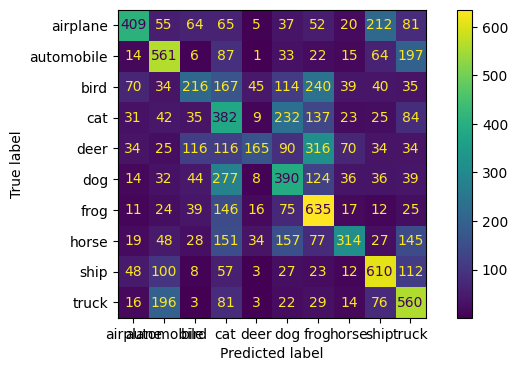

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred=model.predict(test_pca)

cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


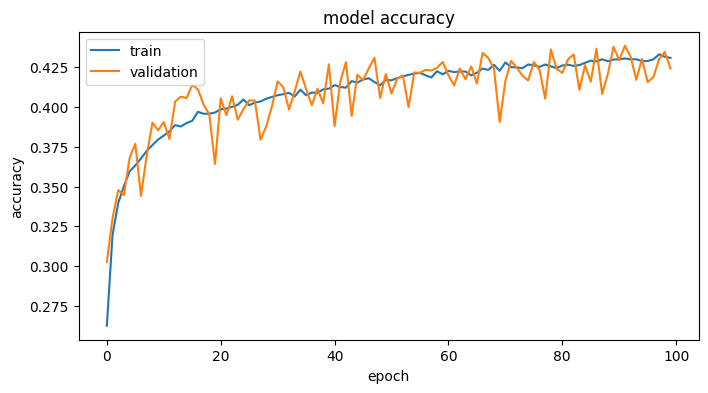

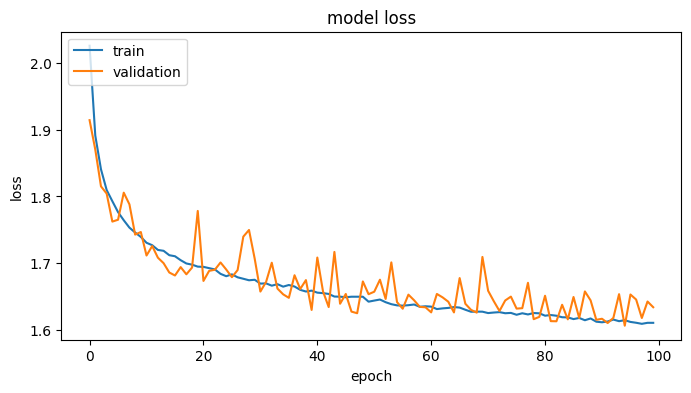

In [ ]:
plt.rcParams["figure.figsize"] = (8,4) # in order to increase the size of the plots
print(history.history.keys())

#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# **Random Centers**

Initialization of centers of RBF network as random samples from the dataset.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input

optimizer='adam'
loss='categorical_crossentropy'
betas = 0.1
nodes = 150

model = Sequential()
model.add(Input(shape=train_pca[0].shape))
model.add(RBFLayer(nodes, initializer=InitCentersRandom(train_pca),
                    betas=betas))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

Shape of initializer: (150, 99)
Shape of dataset X: (50000, 99)


In [ ]:
# check model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbf_layer (RBFLayer)        (None, 150)               15000     
                                                                 
 dense (Dense)               (None, 10)                1510      
                                                                 
Total params: 16510 (64.49 KB)
Trainable params: 16510 (64.49 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
start = timer()

# The best parameters are the defaults
history = model.fit(train_pca, y_train, epochs=100, batch_size=20,
                    validation_data=(test_pca,y_test), shuffle=True,
                    verbose=1)

end = timer()
print("Training time: ", end - start) # time in seconds

Epoch 1/100
2500/2500 [==============================] - 18s 7ms/step - loss: 2.0756 - accuracy: 0.2436 - val_loss: 1.9752 - val_accuracy: 0.2990
Epoch 2/100
2500/2500 [==============================] - 17s 7ms/step - loss: 1.9412 - accuracy: 0.2977 - val_loss: 1.9083 - val_accuracy: 0.3162
Epoch 3/100
2500/2500 [==============================] - 17s 7ms/step - loss: 1.8986 - accuracy: 0.3134 - val_loss: 1.8808 - val_accuracy: 0.3283
Epoch 4/100
2500/2500 [==============================] - 22s 9ms/step - loss: 1.8673 - accuracy: 0.3270 - val_loss: 1.8768 - val_accuracy: 0.3278
Epoch 5/100
2500/2500 [==============================] - 15s 6ms/step - loss: 1.8460 - accuracy: 0.3369 - val_loss: 1.8387 - val_accuracy: 0.3356
Epoch 6/100
2500/2500 [==============================] - 16s 6ms/step - loss: 1.8294 - accuracy: 0.3418 - val_loss: 1.8026 - val_accuracy: 0.3548
Epoch 7/100
2500/2500 [==============================] - 14s 6ms/step - loss: 1.8098 - accuracy: 0.3500 - val_loss: 1.8241 -

In [ ]:
# Evaluate the model on the train set
train_loss, train_acc = model.evaluate(train_pca, y_train)
print("Train accuracy:", train_acc)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_pca, y_test)
print("Test accuracy:", test_acc)

1563/1563 [==============================] - 7s 4ms/step - loss: 1.5857 - accuracy: 0.4436
Train accuracy: 0.44363999366760254
313/313 [==============================] - 1s 4ms/step - loss: 1.6085 - accuracy: 0.4397
Test accuracy: 0.43970000743865967


313/313 [==============================] - 2s 6ms/step


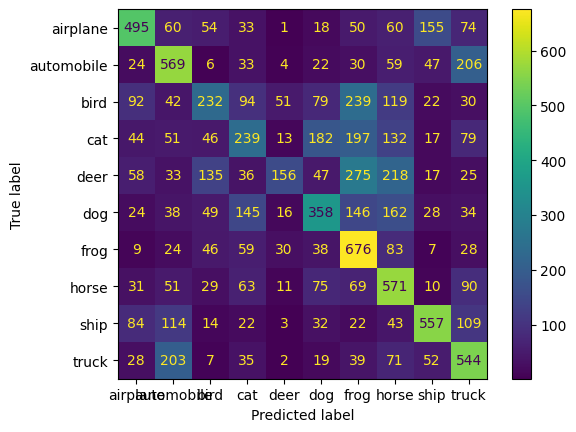

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred=model.predict(test_pca)

cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()

## **Examples of correctly and wrongly classified images**

In [ ]:
y_pred_1d = np.argmax(y_pred, axis=1)
y_test_1d = np.argmax(y_test, axis=1)

print(y_pred_1d.shape)
print(y_test_1d.shape)

(10000,)
(10000,)


For the number  3  sample:
The correct class was:  ship  and it was correctly classified as:  ship


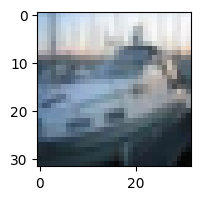

In [ ]:
for i in range(len(y_pred_1d)):
  if y_pred_1d[i]==y_test_1d[i]:
    print("For the number ", i+1, " sample:")
    print("The correct class was: ", classes[y_test_1d[i]], " and it was correctly classified as: ", classes[y_pred_1d[i]])
    break

plt.figure(figsize=(2, 2))
plt.imshow(X_test_not_reshaped[i], cmap=plt.get_cmap('CMRmap'))
plt.show()

For the number  1  sample:
The correct class was:  cat  and it was wrongly classified as:  frog


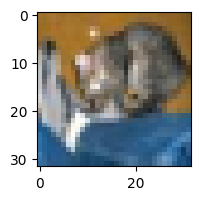

In [ ]:
for i in range(len(y_pred_1d)):
  if y_pred_1d[i]!=y_test_1d[i]:
    print("For the number ", i+1, " sample:")
    print("The correct class was: ", classes[y_test_1d[i]], " and it was wrongly classified as: ", classes[y_pred_1d[i]])
    break

plt.figure(figsize=(2, 2))
plt.imshow(X_test_not_reshaped[i], cmap=plt.get_cmap('CMRmap'))
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


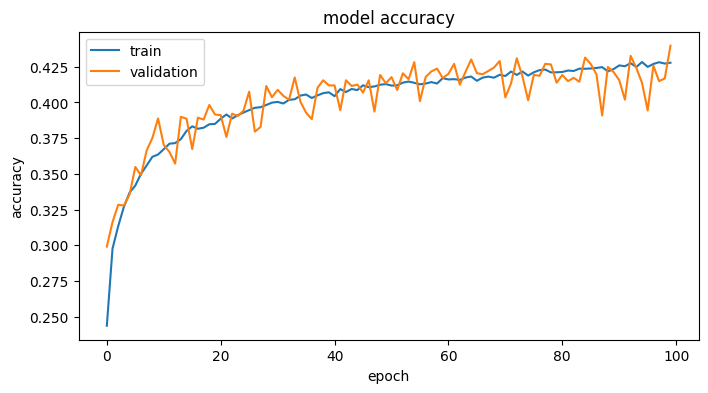

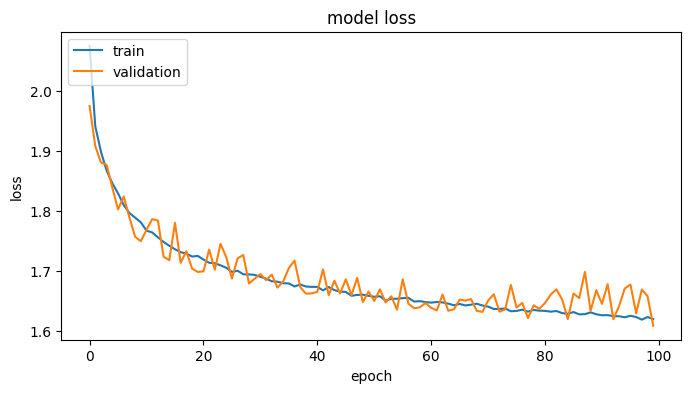

In [ ]:
plt.rcParams["figure.figsize"] = (8,4) # in order to increase the size of the plots
print(history.history.keys())

#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Resources

https://towardsdatascience.com/radial-basis-functions-neural-networks-all-we-need-to-know-9a88cc053448

https://mccormickml.com/2013/08/15/radial-basis-function-network-rbfn-tutorial/

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

https://github.com/PetraVidnerova/rbf_keras

Thanks to the author of the very first citation: Lukas Brausch, et al. Towards a wearable low-cost ultrasound device for classification of muscle activity and muscle fatigue. 2019 doi:10.1145/3341163.3347749